## Initialize Value Class

In [45]:
import math


class Value:
    def __init__(self, data, _op='', _children=(), label='', grad=0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = grad
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        out = f"Value({self.data})"
        return out

    def __add__(self, other):
        out = Value(self.data+other.data, _op='+', _children=(self, other,))

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data*other.data, _op='*', _children=(self, other,))

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += 1-t**2
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

## Define Graphing Function

In [47]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

## Test


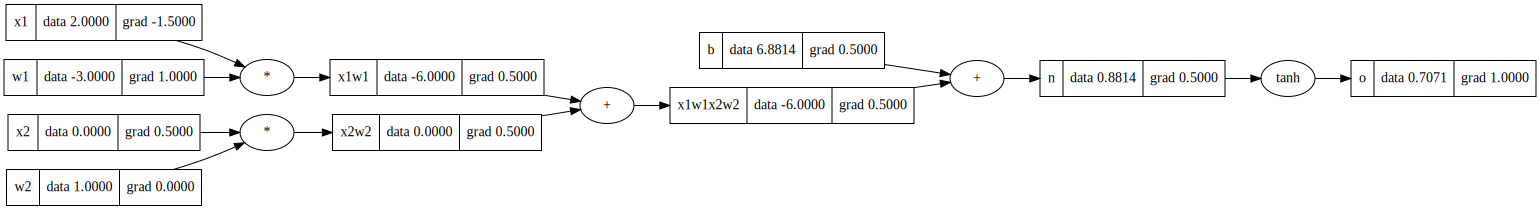

In [46]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()
draw(o)